In [22]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from os.path import exists
import numpy as np
import time, math, sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.facecolor'] = 'white'

sys.path.insert(1, '/home/joeadamo/Research/CovA-NN-Emulator')
from CovNet import Network_Features, Block_Decoder, Block_Encoder, Network_VAE, MatrixDataset, symmetric_log, symmetric_exp, try_gpu, VAE_loss, features_loss, corr_to_cov

In [23]:
# IMPORTANT: Make sure the parameters here are the same as when you trained the network in question!
N = 52500
N_test = int(N*0.1)
train_log = True
train_correlation = False
train_cholesky = True
training_dir = "/home/joeadamo/Research/Data/Training-Set/"
#training_dir = "/home/jadamo/CovA-NN-Emulator/Data/Training-Set/"
save_dir = "/home/joeadamo/Research/CovA-NN-Emulator/Plots/"
#save_dir = "/home/jadamo//CovA-NN-Emulator/Plots/"
BOSS_dir = "/home/joeadamo/Research/Data/BOSS-DR12/"
#BOSS_dir = "/home/jadamo/CovA-NN-Emulator/Data/BOSS-DR12/"
CovaPT_dir = "/home/joeadamo/Research/CovaPT/Example-Data/"
#CovaPT_dir = "/home/jadamo/CovaPT/Example-Data/"
net_dir = "../Data/Cholesky-decomp/"

P_BOSS = np.loadtxt(BOSS_dir+"Cl-BOSS-DR12.dat")
k =np.loadtxt(CovaPT_dir+'k_Patchy.dat')
P0_mean = np.loadtxt(CovaPT_dir+'P0_fit_Patchy.dat')
P2_mean = np.loadtxt(CovaPT_dir+'P2_fit_Patchy.dat')
P4_mean = np.loadtxt(CovaPT_dir+'P4_fit_Patchy.dat')
#TODO: The k-bins between these 2 spectra aren't exactly the same, should I try interpolating?
xi_hat = np.concatenate((P_BOSS[1], P_BOSS[2]))
xi_pi = np.concatenate((P0_mean, P2_mean))
x = torch.from_numpy(xi_hat - xi_pi).to(try_gpu()).float()

F_loss = nn.L1Loss()

In [24]:
# load the trained network
#net = Network_Full(6, 100*100)
net = Network_VAE(train_cholesky).to(try_gpu());       net.eval()
encoder = Block_Encoder().to(try_gpu()); encoder.eval()
decoder = Block_Decoder(train_cholesky).to(try_gpu()); decoder.eval()
net_2 = Network_Features(6, 10).to(try_gpu())
net.load_state_dict(torch.load(net_dir+'network-VAE.params'))
encoder.load_state_dict(net.Encoder.state_dict())
decoder.load_state_dict(net.Decoder.state_dict())
net_2.load_state_dict(torch.load(net_dir+'network-features.params'))

<All keys matched successfully>

In [25]:
# load the test set
t1 = time.time()
test_data = MatrixDataset(training_dir, N_test, int(N*0.9), train_log, train_correlation, train_cholesky)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 4.10 s


In [26]:
# test the matrix -> features -> matrix pipeline
t1 = time.time()
loss_data = np.zeros(N_test)
chi_min = 1000000; chi_max = 0; chi_avg = 0.
num_bad = 0; avg_bad = 0;
net.eval()
for (i, batch) in enumerate(test_loader):
    params = batch[0]; matrix = batch[1]
    prediction, mu, log_var = net(matrix.view(1, 100, 100))
    prediction = prediction.view(100,100); matrix = matrix.view(100,100)
    #loss = F_loss(prediction, matrix)
    loss = VAE_loss(prediction, matrix, mu, log_var)
    loss_data[i] = loss.item()
    if train_cholesky or train_correlation:
        if train_cholesky:
            prediction = torch.matmul(symmetric_exp(prediction), torch.t(symmetric_exp(prediction)))
            matrix = torch.matmul(symmetric_exp(matrix), torch.t(symmetric_exp(matrix)))
        elif train_correlation:
            prediction = corr_to_cov(prediction)
            matrix = corr_to_cov(matrix)
        perc_predict = torch.linalg.inv(prediction.detach()); perc_predict = perc_predict.view(100,100)
        perc_actual  = torch.linalg.inv(matrix.detach()); perc_actual = perc_actual.view(100,100)
    else:
        perc_predict = torch.linalg.inv(symmetric_exp(prediction.detach())); perc_predict = perc_predict.view(100,100)
        perc_actual  = torch.linalg.inv(symmetric_exp(matrix.detach())); perc_actual = perc_actual.view(100,100)
    chi_squared_1 = torch.matmul(torch.t(x), torch.matmul(perc_predict, x))
    chi_squared_2 = torch.matmul(torch.t(x), torch.matmul(perc_actual, x))
    chi_min = min(chi_min, abs(chi_squared_1 - chi_squared_2)); chi_max = max(chi_max, abs(chi_squared_1 - chi_squared_2)); chi_avg += abs(chi_squared_1 - chi_squared_2)
    
    #eigen, v = torch.linalg.eigh(symmetric_exp(prediction))
    #if torch.all(eigen > 0.) == False:
    #    num_bad += 1
    #    avg_bad += len(torch.where(eigen < 0))
    
t2 = time.time()
print("Done!, took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))
print("min loss: {:0.3f}, max loss {:0.3f}, avg loss: {:0.3f}".format(np.amin(loss_data), np.amax(loss_data), np.sum(loss_data) / N_test))
print("chi squared absolute errors: [{:0.2f}, {:0.2f}], avg = {:0.3f}".format(chi_min, chi_max, chi_avg / N_test))
if num_bad != 0:
    print(num_bad, "matrices have negative eigenvalues!, average number of negative eigenvalues =", 1.*avg_bad / num_bad)

Done!, took 0 minutes 29.91 seconds
min loss: 69.393, max loss 5542.870, avg loss: 564.313
chi squared absolute errors: [0.02, 578203684391878656.00], avg = 110134034432000.000


In [27]:
# test the params -> features -> matrix pipeline
chi_min = 1000000; chi_max = 0; chi_avg = 0.
errors = torch.zeros(N_test)
t1 = time.time()
for (i, batch) in enumerate(test_loader):
    params = batch[0]; matrix = batch[1]
    features = net_2(params); prediction = decoder(features.view(1,10)).view(100, 100)
    matrix = matrix.view(100,100)
    
    if train_cholesky or train_correlation:
        if train_cholesky:
            prediction = torch.matmul(symmetric_exp(prediction), torch.t(symmetric_exp(prediction)))
            matrix = torch.matmul(symmetric_exp(matrix), torch.t(symmetric_exp(matrix)))
        elif train_correlation:
            prediction = corr_to_cov(prediction)
            matrix = corr_to_cov(matrix)
        perc_predict = torch.linalg.inv(prediction.detach()); perc_predict = perc_predict.view(100,100)
        perc_actual  = torch.linalg.inv(matrix.detach()); perc_actual = perc_actual.view(100,100)
    else:
        perc_predict = torch.linalg.inv(symmetric_exp(prediction.detach())); perc_predict = perc_predict.view(100,100)
        perc_actual  = torch.linalg.inv(symmetric_exp(matrix.detach())); perc_actual = perc_actual.view(100,100)
        
    chi_squared_1 = torch.matmul(torch.t(x), torch.matmul(perc_predict, x))
    chi_squared_2 = torch.matmul(torch.t(x), torch.matmul(perc_actual, x))
    chi_err = abs(chi_squared_1 - chi_squared_2)
    errors[i] = chi_err
    chi_min = min(chi_min, chi_err); chi_max = max(chi_max, chi_err); chi_avg += chi_err

errors = errors.to("cpu").detach().numpy()
t2 = time.time()
print("Done!, took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))
print("chi squared absolute errors: [{:0.2f}, {:0.2f}], avg = {:0.3f}".format(chi_min, chi_max, chi_avg / N_test))

Done!, took 0 minutes 17.76 seconds
chi squared absolute errors: [0.03, 420.61], avg = 91.331


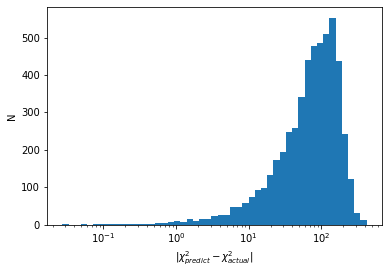

In [28]:
plt.hist(errors, bins=np.logspace(np.log10(np.amin(errors)), np.log10(np.amax(errors)), 50))
plt.xlabel(r"$|\chi_{predict}^2 - \chi_{actual}^2|$")
plt.ylabel("N")
plt.xscale("log")

Indexes: 2669 751


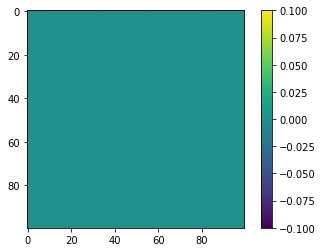

In [8]:
# Let's first test that seperate parameter imputs give different outputs
idx1 = np.random.randint(0, N_test); idx2 = np.random.randint(0, N_test)
params1 = test_data[idx1][0]; params2 = test_data[idx2][0]
cov_actual1 = test_data[idx1][1]; cov_actual2 = test_data[idx2][1]

features = net_2(params1); cov_predict1 = decoder(features.view(1,10)).view(100, 100).to("cpu").detach()
features = net_2(params2); cov_predict2 = decoder(features.view(1,10)).view(100, 100).to("cpu").detach()

# If this plot has mostly 0's everywhere than the network isn't distiguishing between cosmologies!
print("Indexes:", idx1, idx2)
plt.imshow(abs(cov_predict1 - cov_predict2))
cbar = plt.colorbar()

loss =  735.4584350585938
rediction = 735.458, KL Divergence = 0.000
sample 1093, params: tensor([ 7.1748e+01,  2.8740e-01,  1.2409e-01,  1.7986e-09,  1.8519e+00,
        -3.3881e-03])


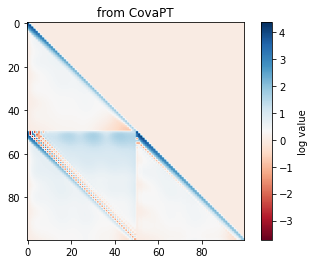

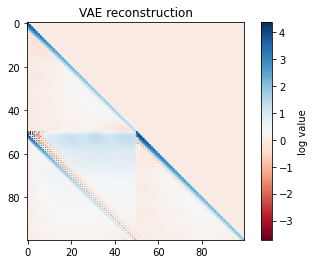

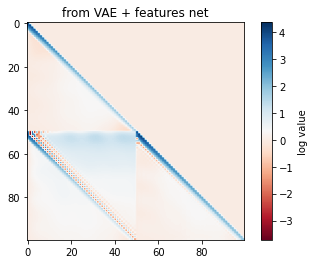

In [9]:
# Let's do some more detailed analysis on a random matrix from the test set
idx = np.random.randint(0, N_test)
params = test_data[idx][0]
# matrix from CovaPT
cov_actual = test_data[idx][1]
# matrix from VAE reconstruction
cov_VAE, mu, log_var = net(cov_actual.view(1,100,100)); cov_VAE = cov_VAE.view(100,100)
# matrix from parameters -> features and features -> matrix
features = net_2(params); cov_predict = decoder(features.view(1,10)).view(100, 100)

RLoss = F.l1_loss(cov_VAE, cov_actual, reduction="sum")
KLD = 0.5 * torch.sum(log_var.exp() - log_var - 1 + mu.pow(2))

print("loss = ", VAE_loss(cov_VAE, cov_actual, mu, log_var).item())
print("rediction = {:0.3f}, KL Divergence = {:0.3f}".format(RLoss, KLD)) 
print("sample " + str(idx) + ", params:", params)
cov_VAE = cov_VAE.to("cpu").detach(); cov_predict = cov_predict.to("cpu").detach(); cov_actual = cov_actual.to("cpu").detach();

plt.figure()
plt.title("from CovaPT")
plt.imshow(cov_actual, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("VAE reconstruction")
plt.imshow(cov_VAE, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("from VAE + features net")
plt.imshow(cov_predict, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

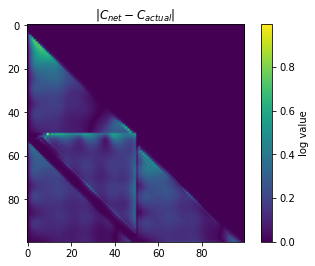

In [10]:
# Visualize the difference between generated and actual matrix
C_residual = abs(cov_predict - cov_actual)
plt.title(r"$|C_{net} - C_{actual}|$")
plt.imshow(C_residual)
cbar = plt.colorbar()
cbar.set_label("log value")

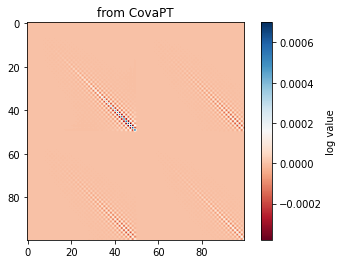

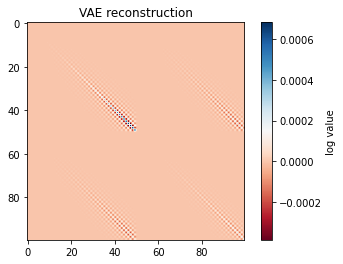

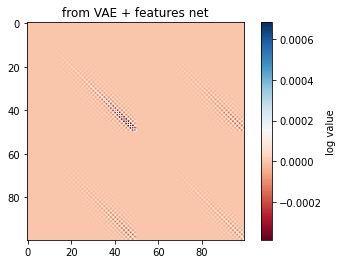

In [11]:
# visualize the inverse of these matrices
if train_correlation or train_cholesky:
    if train_correlation:
        cov_actual1 = corr_to_cov(cov_actual); cov_VAE1 = corr_to_cov(cov_VAE); cov_predict1 = corr_to_cov(cov_predict); 
    elif train_cholesky:
        cov_actual1 = torch.matmul(symmetric_exp(cov_actual.to(try_gpu())), torch.t(symmetric_exp(cov_actual.to(try_gpu()))))
        cov_VAE1 = torch.matmul(symmetric_exp(cov_VAE.to(try_gpu())), torch.t(symmetric_exp(cov_VAE.to(try_gpu()))))
        cov_predict1 = torch.matmul(symmetric_exp(cov_predict.to(try_gpu())), torch.t(symmetric_exp(cov_predict.to(try_gpu()))))
    perc_actual = torch.linalg.inv(cov_actual1.to(try_gpu())).to("cpu")
    perc_VAE = torch.linalg.inv(cov_VAE1.to(try_gpu())).to("cpu")
    perc_predict = torch.linalg.inv(cov_predict1.to(try_gpu())).to("cpu")
else:
    perc_actual = torch.linalg.inv(symmetric_exp(cov_actual.to(try_gpu()))).to("cpu")
    perc_VAE = torch.linalg.inv(symmetric_exp(cov_VAE.to(try_gpu()))).to("cpu")
    perc_predict = torch.linalg.inv(symmetric_exp(cov_predict.to(try_gpu()))).to("cpu")

plt.figure()
plt.title("from CovaPT")
plt.imshow(perc_actual, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("VAE reconstruction")
plt.imshow(perc_VAE, cmap="RdBu")#, vmin=np.amin(cov_actual), vmax=np.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("from VAE + features net")
plt.imshow(perc_predict, cmap="RdBu")#, vmin=np.amin(cov_actual), vmax=np.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

In [12]:
# Test chi squared for the predicted matrix
x_c = x.to("cpu")
chi_s_actual = torch.matmul(torch.t(x_c), torch.matmul(perc_actual, x_c))
chi_s_VAE = torch.matmul(torch.t(x_c), torch.matmul(perc_VAE, x_c))
chi_s_predict = torch.matmul(torch.t(x_c), torch.matmul(perc_predict, x_c))
print("chi squared")
print("CovaPT: {:0.3f},\t VAE: {:0.3f},\t full prediction: {:0.3f}".format(chi_s_actual, chi_s_VAE, chi_s_predict))

chi squared
CovaPT: 1418.575,	 VAE: 1250.645,	 full prediction: 1252.588


In [13]:
# Test for positive definite-ness
pos_diag = True
for i in range(cov_predict.shape[0]):
    if cov_predict[i,i] <= 0:
        pos_diag = False
print("diagonal is all positive:", pos_diag)

diagonal is all positive: True


tensor(0.3279)


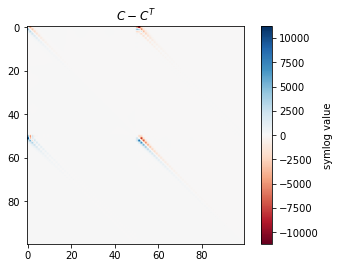

In [14]:
cov_predict2 = cov_predict.to(try_gpu())
cov_sym = (symmetric_exp(cov_predict2) + symmetric_exp(torch.t(cov_predict2)))
cov_asym = (symmetric_exp(cov_predict2) - symmetric_exp(torch.t(cov_predict2)))
symmetric_val = torch.linalg.norm(cov_asym, 2) / torch.linalg.norm(cov_sym, 2)
print(symmetric_val)

plt.figure()
plt.title(r"$C - C^T$")
#plt.imshow(cov_test2 - cov_test2.T, cmap="RdBu")
plt.imshow(cov_asym.cpu(), cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("symlog value")

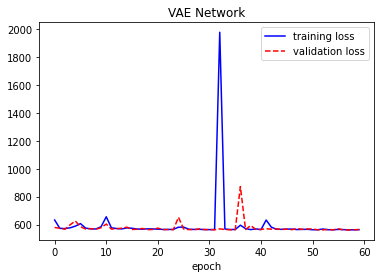

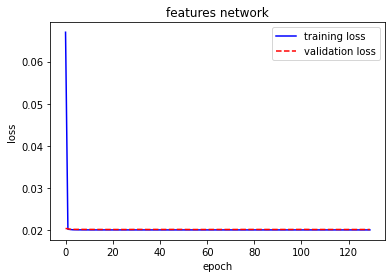

In [15]:
train_loss = torch.load(net_dir+"train_loss.dat")
valid_loss = torch.load(net_dir+"valid_loss.dat")
train_loss_f = torch.load(net_dir+"train_loss-features.dat")
valid_loss_f = torch.load(net_dir+"valid_loss-features.dat")

epoch = range(len(train_loss))
plt.title("VAE Network")
plt.plot(epoch, train_loss, color="blue", label="training loss")
plt.plot(epoch, valid_loss, color="red", ls="--", label="validation loss")
plt.xlabel("epoch")
#plt.ylabel("loss")
#plt.ylim(800, 4000)
#plt.yscale("log")
plt.legend()

epoch_f = range(len(train_loss_f))
plt.figure()
plt.title("features network")
plt.plot(epoch_f, train_loss_f, color="blue", label="training loss")
plt.plot(epoch_f, valid_loss_f, color="red", ls="--", label="validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.yscale("log")
plt.legend()

In [16]:
# try to visualize the feature space
features = torch.zeros(N, 10, device=try_gpu())
t1 = time.time()
for (i, batch) in enumerate(test_loader):
    params = batch[0]; matrix = batch[1]
    z, mu, log_var = encoder(matrix.view(1, 100, 100))
    features[i] = z
    
features = features.to("cpu").detach().numpy()
t2 = time.time()
print("Done!, took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))

Done!, took 0 minutes 11.34 seconds


[ 0.00051022 -0.00247741  0.00047758 -0.00253502 -0.00160188 -0.0002651
 -0.00149234 -0.00019818  0.00173167  0.00067344]


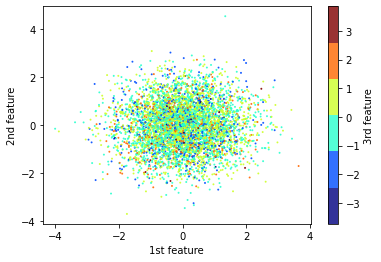

In [17]:
N_colors = 6 # <- number of colors
base = plt.cm.get_cmap("jet")
color_list = base(np.linspace(0, 1, N_colors))
cmap_name = base.name + str(N)
cmap = base.from_list(cmap_name, color_list, N_colors)

print(np.mean(features, axis=0))
f1 = 0; f2 = 1; f3 = 2
plt.scatter(features[:,f1], features[:,f2], cmap=cmap, c=features[:,f3], alpha=0.8, s=1)
plt.xlabel("1st feature")
plt.ylabel("2nd feature")
cbar = plt.colorbar()
cbar.set_label("3rd feature")

## Extra tests for debugging

In [18]:
# test to see what outputs from the training / validation sets looks like
# I'm only loading in a subset of the whole training set to save memory / time
t1 = time.time()
train_data = MatrixDataset(training_dir, int(N*0.1), 0, train_log, train_correlation, train_cholesky)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 4.06 s


loss =  864.3358154296875
rediction = 864.336, KL Divergence = 0.000
sample 3476, params: tensor([ 6.9765e+01,  3.2781e-01,  1.4466e-01,  1.9273e-09,  1.9997e+00,
        -9.1716e-01])


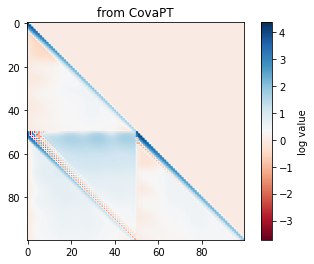

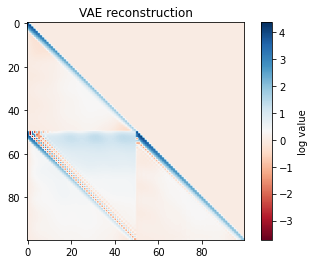

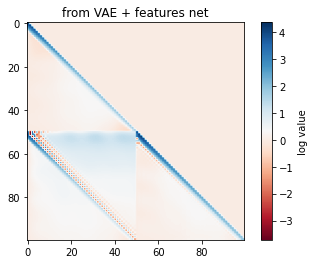

In [19]:
idx = np.random.randint(0, N*0.1)
params = train_data[idx][0]
# matrix from CovaPT
cov_actual = train_data[idx][1]

cov_VAE, mu, log_var = net(cov_actual.view(1,100,100)); cov_VAE = cov_VAE.view(100,100)
# matrix from parameters -> features and features -> matrix
features = net_2(params); cov_predict = decoder(features.view(1,10)).view(100, 100)

RLoss = F.l1_loss(cov_VAE, cov_actual, reduction="sum")
KLD = 0.5 * torch.sum(log_var.exp() - log_var - 1 + mu.pow(2))

print("loss = ", VAE_loss(cov_VAE, cov_actual, mu, log_var).item())
print("rediction = {:0.3f}, KL Divergence = {:0.3f}".format(RLoss, KLD)) 
print("sample " + str(idx) + ", params:", params)
cov_VAE = cov_VAE.to("cpu").detach(); cov_predict = cov_predict.to("cpu").detach(); cov_actual = cov_actual.to("cpu").detach();

plt.figure()
plt.title("from CovaPT")
plt.imshow(cov_actual, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("VAE reconstruction")
plt.imshow(cov_VAE, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("from VAE + features net")
plt.imshow(cov_predict, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

Indexes: 3191 2764


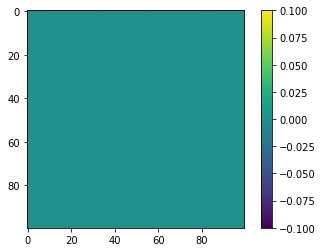

In [20]:
# Let's first test that seperate parameter imputs give different outputs
idx1 = np.random.randint(0, N*0.1); idx2 = np.random.randint(0, N*0.1)
params1 = train_data[idx1][0]; params2 = train_data[idx2][0]
cov_actual1 = train_data[idx1][1]; cov_actual2 = train_data[idx2][1]

features = net_2(params1); cov_predict1 = decoder(features.view(1,10)).view(100, 100).to("cpu").detach()
features = net_2(params2); cov_predict2 = decoder(features.view(1,10)).view(100, 100).to("cpu").detach()

# If this plot has mostly 0's everywhere than the network isn't distiguishing between cosmologies!
print("Indexes:", idx1, idx2)
plt.imshow(abs(cov_predict1 - cov_predict2))
cbar = plt.colorbar()